# Trial 1: XGBoost

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.impute import KNNImputer

# Load data
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [ ]:
# Mapping dwelling types to categories
dwelling_map = {
    **{dw: "Apartments" for dw in [
        "Appartement", "Appartementengebouw", "Assistentie-appartement", "Bel-Étage", "Dakappartement",
        "Duplex", "Gelijkvloers app.", "Loft", "Penthouse", "Serviceflat", "Studio", "Studio met slaaphoek"
    ]},
    **{dw: "Houses" for dw in [
        "Arbeiderswoning", "Boerderij", "Bungalow", "Burgerswoning", "Cottage", "Eengezinswoning",
        "Fermette", "Herenhuis", "Herenwoning", "Hoekwoning", "Hoeve", "Kangoeroewoning", "Koppelvilla",
        "Koppelwoning", "Moderne villa", "Pastorijwoning", "Rijwoning", "Villa", "Villa-landhuis", "Woning"
    ]},
    **{dw: "Other" for dw in [
        "Andere", "Buitenverblijf", "Gemengd gebruik", "Kasteel", "Uitzonderlijke woning",
        "Vakantiewoning", "Woonboot"
    ]}
}
train["Category"] = train["subtype"].map(dwelling_map).fillna("Other")
test["Category"] = test["subtype"].map(dwelling_map).fillna("Other")

In [ ]:
# Classify location based on postcode
def classify_location(postcode):
    if pd.isna(postcode):
        return "Unknown"  # Handle missing postcodes
    
    postcode = str(postcode).zfill(4)  # Ensure it's a 4-digit string
    first_digit, second_digit, third_digit = map(int, postcode[:3])  # Convert only once
    
    if first_digit in {1, 2, 3, 4, 9} and second_digit in {0, 1, 2, 3, 4} and third_digit in {0, 1}:
        return "Urban"
    elif (
        (first_digit in {1, 2, 3, 4, 9} and second_digit in {5, 6, 7}) or
        (first_digit in {5, 6, 7, 8} and second_digit in {0, 1, 2, 3, 4}) or
        (first_digit in {5, 6, 7, 8} and second_digit in {5, 6} and third_digit in {0, 1, 2, 3, 4, 5})
    ):
        return "Suburban"
    else:
        return "Rural"

train["Location_Type"] = train["postcode"].apply(classify_location)
test["Location_Type"] = test["postcode"].apply(classify_location)

In [ ]:
# Energy efficiency classification
energy_bins = np.array([-float("inf"), 100, 200, 300, 400, 500, float("inf")])
energy_labels = np.array(["A", "B", "C", "D", "E", "F"])

def classify_energy_label(energy):
    if pd.isna(energy):
        return "Unknown"
    return energy_labels[np.searchsorted(energy_bins, energy, side="right") - 1]

train["energy_label"] = train["energy_value"].apply(classify_energy_label)
test["energy_label"] = test["energy_value"].apply(classify_energy_label)

In [ ]:
# Impute missing numerical values with category-wise median
imputed_cols = ["area", "energy_value"]
train[imputed_cols] = train.groupby("Category")[imputed_cols].transform(lambda x: x.fillna(x.median()))
test[imputed_cols] = test.groupby("Category")[imputed_cols].transform(lambda x: x.fillna(x.median()))

In [ ]:
# KNN Imputation for lat/lon
imputer = KNNImputer(n_neighbors=5)
train[["lat", "lon"]] = imputer.fit_transform(train[["lat", "lon"]])
test[["lat", "lon"]] = imputer.transform(test[["lat", "lon"]])

In [ ]:
# Handle outliers with Winsorization
def winsorize(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return np.clip(series, lower_bound, upper_bound)

outlier_cols = ["area", "energy_value", "foto_amount", "price"]
for col in outlier_cols:
    train[col] = winsorize(train[col])
    if col != "price":  
        test[col] = winsorize(test[col])

In [ ]:
# One-hot encoding for categorical variables
train = pd.get_dummies(train, columns=["Location_Type", "energy_label"], drop_first=True)
test = pd.get_dummies(test, columns=["Location_Type", "energy_label"], drop_first=True)

# Ordinal encoding for province
train["province"] = train["province"].astype("category").cat.codes
test["province"] = test["province"].astype("category").cat.codes

# Ordinal encoding for Category
train["Category"] = train["Category"].astype("category").cat.codes
test["Category"] = test["Category"].astype("category").cat.codes

In [ ]:
# Normalize Numerical Features
scaler_features = MinMaxScaler()
power_transformer = PowerTransformer(method="yeo-johnson")

continuous_cols_train = ["area", "energy_value", "foto_amount"]
continuous_cols_price = ["price"]

scaler_features.fit(train[continuous_cols_train])
train[continuous_cols_train] = scaler_features.transform(train[continuous_cols_train])
test[continuous_cols_train] = scaler_features.transform(test[continuous_cols_train])

train["price"] = power_transformer.fit_transform(train[["price"]])

In [ ]:
# Drop unnecessary columns
train = train.drop(columns=["id", "advertiser", "subtype", "sticker", "price_drop_date"])
test = test.drop(columns=["advertiser", "subtype", "sticker", "price_drop_date"])

In [ ]:
# Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 1, 10),
        "alpha": trial.suggest_float("alpha", 1, 10),
        "objective": "reg:pseudohubererror",
        "random_state": 42,
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    y_pred = model.predict(X_valid)
    return mean_absolute_error(y_valid, y_pred)

X = train.drop(columns=["price"])
y = train["price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best parameters:", best_params)

In [ ]:
# Train final model with best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X, y)

# Compute Mean Absolute Error on validation set
y_valid_pred = best_model.predict(X_valid)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
print("Validation MAE:", mae_valid)

In [ ]:
# Predict on test set
test_features = test.drop(columns=["id", "prediction"], errors="ignore")
test_pred = best_model.predict(test_features)

test_pred = power_transformer.inverse_transform(test_pred.reshape(-1, 1)).flatten() # Reverse Power Transformation on target
test["prediction"] = test_pred
print(test[["id", "prediction"]].head(10))

In [ ]:
# Compute Prediction Intervals
lower_bound = test_pred * 0.90 # 90% of the prediction
upper_bound = test_pred * 1.10 # 110% of the prediction

# Submission
submission = pd.DataFrame({
    "ID": test["id"],
    "LOWER": lower_bound,
    "UPPER": upper_bound,
    "PRED": test_pred
})
submission.to_csv("xgboost_submission_3.csv", index=False)

# Trial 2: AutoML

In [1]:
# Imports
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
from flaml import AutoML
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance

# Load data
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

c:\Users\fabri\Desktop\uni\MSDS\2024-2025\Semester 2\Advanced Analytics in a Big Data World\Project\Assignment 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# KNN imputation for lat/lon
imputer = KNNImputer(n_neighbors=5)
train[["lat", "lon"]] = imputer.fit_transform(train[["lat", "lon"]])
test[["lat", "lon"]] = imputer.transform(test[["lat", "lon"]])

# KMeans clustering on lat/lon to create 'location_cluster'
kmeans = KMeans(n_clusters=10, random_state=50)
kmeans.fit(train[["lat", "lon"]])
train["location_cluster"] = kmeans.predict(train[["lat", "lon"]])
test["location_cluster"] = kmeans.predict(test[["lat", "lon"]])

In [3]:
# Preprocessing and feature setup
cat_cols = ['province', 'energy_lab', 'advertiser', 'subtype', 'sticker', 'location_cluster']
for col in cat_cols:
    for df in [train, test]:
        if col in df.columns:
            df[col] = df[col].astype("category")

X = train.drop(columns=["id", "price"])
y = train["price"]
X_test = test.drop(columns=["id"])

for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

for col in X_test.columns:
    if X_test[col].dtype == "object":
        X_test[col] = X_test[col].astype("category")

In [4]:
# Lower bound model (10th percentile)
model_lower = lgb.LGBMRegressor(objective='quantile', alpha=0.1, random_state=50)
model_lower.fit(X, y)
pred_lower = model_lower.predict(X_test)

# Upper bound model (90th percentile)
model_upper = lgb.LGBMRegressor(objective='quantile', alpha=0.9, random_state=50)
model_upper.fit(X, y)
pred_upper = model_upper.predict(X_test)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3270
[LightGBM] [Info] Number of data points in the train set: 27071, number of used features: 17
[LightGBM] [Info] Start training from score 178500.015625
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002517 seconds.
You can set `force_col_

In [5]:
# Point prediction using FLAML
automl = AutoML()
automl.fit(X_train=X, y_train=y, task='regression', time_budget=600, seed=50)
pred_point = automl.predict(X_test)

[flaml.automl.logger: 05-05 17:30:36] {1728} INFO - task = regression
[flaml.automl.logger: 05-05 17:30:36] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-05 17:30:36] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-05 17:30:36] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-05 17:30:36] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-05 17:30:36] {2393} INFO - Estimated sufficient time budget=4349s. Estimated necessary time budget=31s.
[flaml.automl.logger: 05-05 17:30:36] {2442} INFO -  at 0.6s,	estimator lgbm's best error=0.8264,	best estimator lgbm's best error=0.8264
[flaml.automl.logger: 05-05 17:30:36] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-05 17:30:37] {2442} INFO -  at 1.1s,	estimator lgbm's best error=0.8264,	best estimator lgbm's best error=0.8264
[flaml.automl.logger: 05-05 17:30:37] {2258} 

In [6]:
# Final submission: ID, LOWER, UPPER, PRED
submission = pd.DataFrame({
    "ID": test["id"],
    "LOWER": pred_lower,
    "UPPER": pred_upper,
    "PRED": pred_point
})

# Clamp PRED inside bounds
submission["LOWER"] = submission[["LOWER", "UPPER"]].min(axis=1)
submission["UPPER"] = submission[["LOWER", "UPPER"]].max(axis=1)
submission["PRED"] = submission[["PRED", "LOWER"]].max(axis=1)
submission["PRED"] = submission[["PRED", "UPPER"]].min(axis=1)

# Export CSV without header for submission
submission.to_csv("automl_submission_2_final.csv", index=False, header=False)
submission.head()

,ID,LOWER,UPPER,PRED
0,te0,312932.444747,753595.806825,534582.639084
1,te1,293241.706759,508759.269291,413103.015537
2,te2,168794.856980,235441.126812,201258.301036
3,te3,127271.377842,212590.039819,138736.864078
4,te4,336242.309805,422868.826887,372113.140303


             feature  importance
8               area        7000
15       foto_amount        5800
0         advertiser        5739
9         added_time        5679
16      energy_value        4320
13               lat        4273
14               lon        3367
12          postcode        2863
10          bedrooms        2838
4       energy_label        2698
1            subtype        1925
6   location_cluster        1823
5           province        1049
11      new_building         373
2            sticker         270
7      is_appartment         148
3    price_drop_date          39


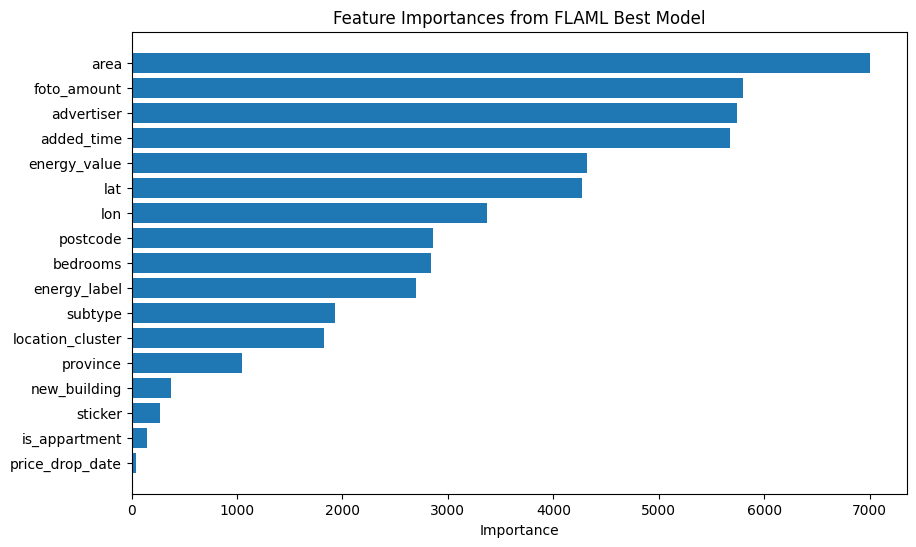

In [10]:
# Get feature importances from the best model found by FLAML
importances = automl.model.feature_importances_
feature_names = automl.feature_names_in_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from FLAML Best Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Get the underlying native LightGBM model
native_lgbm_model = best_model.model

# Use the same features as used for training
X_for_shap = pd.DataFrame(X, columns=automl.feature_names_in_)

explainer = shap.TreeExplainer(native_lgbm_model)
shap_values = explainer.shap_values(X_for_shap)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_for_shap, plot_type="bar")

# Detailed summary plot (distribution of impacts)
shap.summary_plot(shap_values, X_for_shap)